 <img src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png"  width="300" height="300" /> 
    
    
#### <center>  Simulación de Procesos Financieros. 

**Nombres:** Ana Sofia Dürrmüller Acosta y Daniela Michel Mercado  
**Expedientes:** 723489 y 724506  
**Profesor:** Oscar David Jaramillo Zuluaga.  
**Link Github**: https://github.com/danielamichel/Proyecto1_DMichel_ADurrmuller

#### <center> Proyecto TEMA-2 


#### <center> <font color='red'> 1.1 COVID-19    
<img src="https://www.paho.org/sites/default/files/styles/max_1500x1500/public/hero/2020-03/covid-19-1190x574-2-full.jpg?itok=ZtEWNGB3" width="400" height="400" />

#### <center> 1.2 Objetivos 
 **Objetivo General**: A lo largo de este proyecto se pretende predecir el comportamiento a futuro del virus COVID-19 tomando en cuenta las variables seleccionadas.
    
> **Objetivos Especificos**:
- Encontrar la media de crecimiento o descenso de los casos nuevos en Italia y Canáda. 
- Encontrar la media de crecimiento o descenso de las nuevas muertes en Italia y Canáda. 

#### <center> 1.3 Definición del Problema.
> El COVID‑19 es la enfermedad infecciosa causada por el coronavirus que se ha descubierto más recientemente. Tanto este nuevo virus como la enfermedad que provoca eran desconocidos antes de que estallara el brote en Wuhan (China) en diciembre de 2019. Actualmente la COVID‑19 es una pandemia que afecta a muchos países de todo el mundo.

#### <center> 1.4 Nodos y Variables que se decidieron simular y porqué

> Los nodos que tomaremos para la simulacion de nuestro proyecto son:
- Casos nuevos
    1. Casos nuevos Italia 
    2. Casos nuevos Canadá
- Muertes nuevas
    1. Muertes nuevas Italia
    2. Muertes nuevas Canadá

>Tomamos estas variables porque son las mas representativas para hacer la simulación y poder comparar resultados entre Canadá e Italia.


#### <center> 1.5 Definición de hipótesis y supuestos.

•El modelo a realizar únicamente es funcional si y solo sí se predicen o interpretan información de los siguientes 10 dias para Canadá e Italia

• Se va a tomar como el día más reciente el último dato que tiene el dataframe, el dataframe va de 24 de febrero del 2020 a 3 de noviembre del 2021.

• Las variables a modelar son las más significativas para predecir la información más importante del impacto del virus y su comportamiento.

• Los datos que se encuentran en el Data Frame no tienen algun tipo de sesgo o fallo, son correctos.


#### <center> 1.6 Obtención de base de datos
https://ourworldindata.org/explorers/coronavirus-data-explorer?facet=none&Metric=Confirmed+deaths&Interval=7-day+rolling+average&Relative+to+Population=true&Align+outbreaks=false&country=ITA~CAN   
La base de datos fue obtenida de la página "Our world in data",con datos historicos del impacto del covid en dividio en diferentes variables por país.
Nuestra base de datos inicia con datos del 24 de febrero del 2020 hasta el 3 de noviembre del 2021.
    

<img src=" file:///Users/ana/Desktop/Proyecto%20SDPF.jpg" >


#### <center> Diagrama
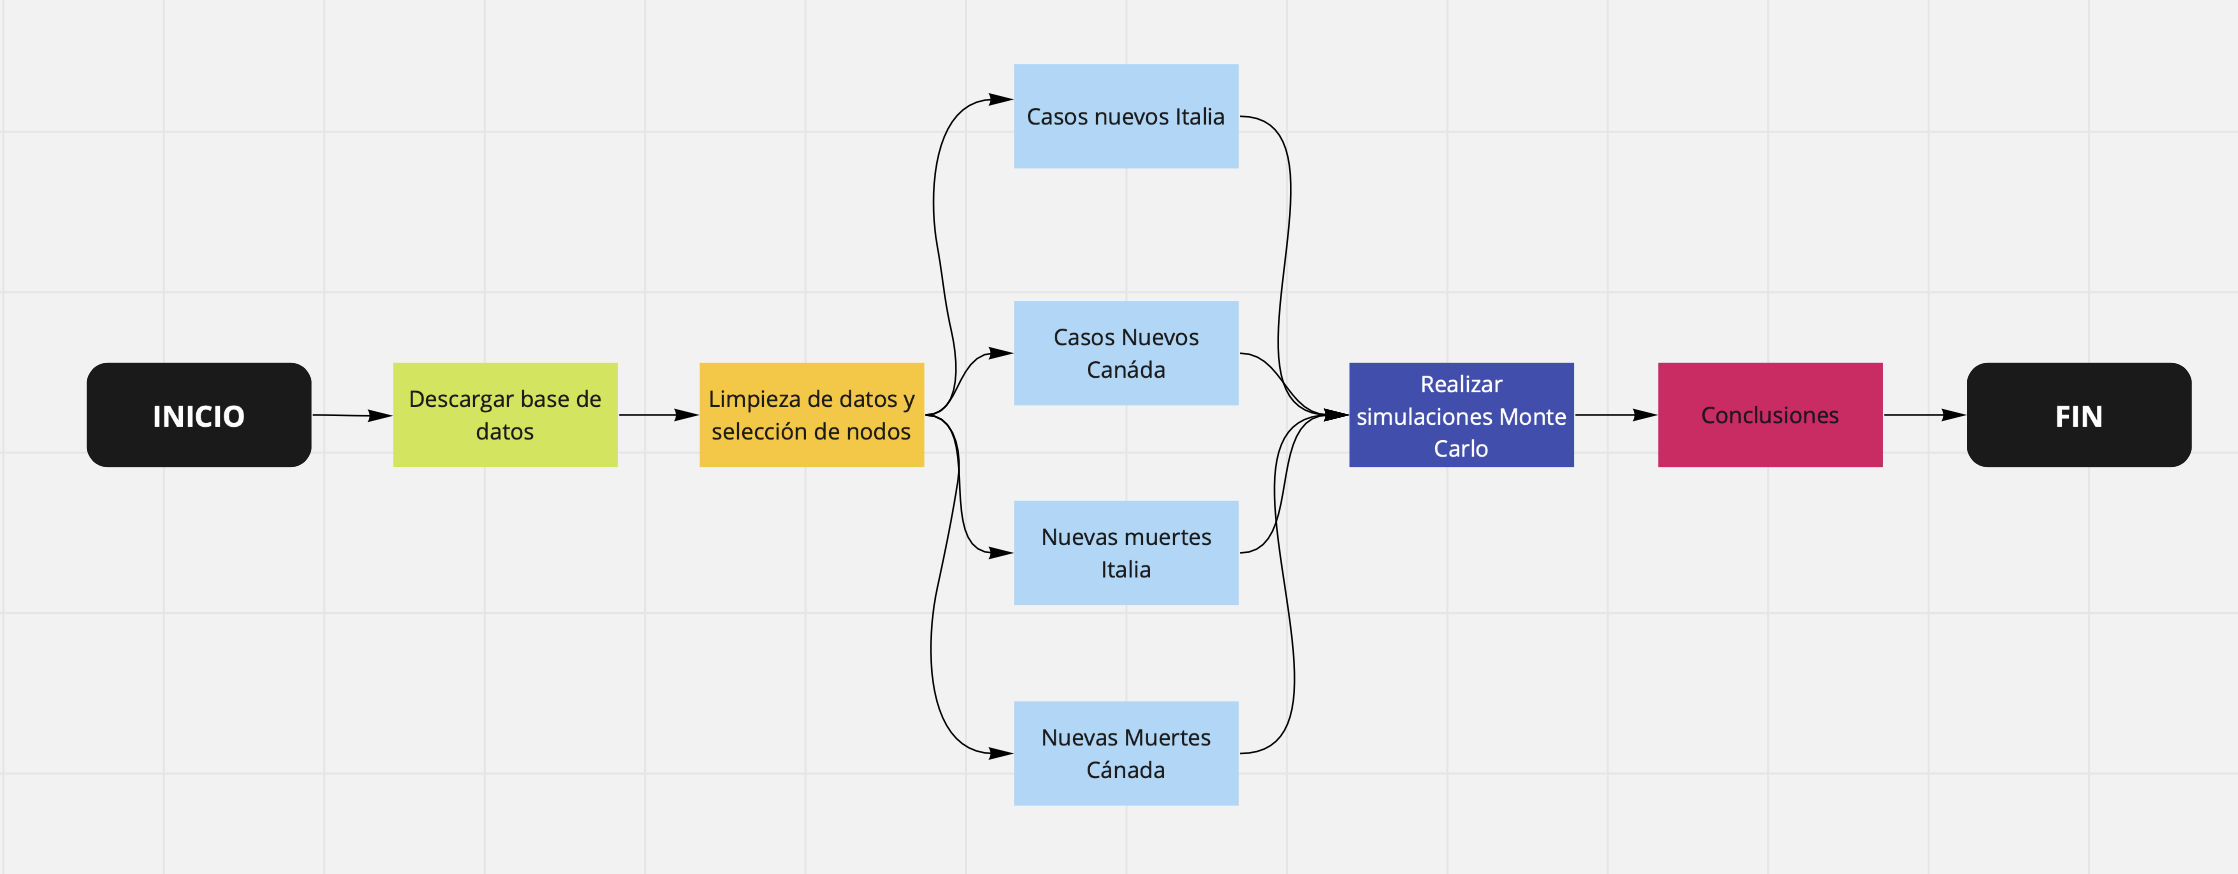

## <center> Base de datos

In [1]:
# Importacion de todas las librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy import optimize
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

In [2]:
# Lectura de Data Frame
data = pd.read_csv('./cases_deaths_data.csv')
data = data[(data.iso_code == 'ITA') | (data.iso_code == 'CAN')]

## <center> Limpieza de datos

In [3]:
clean_data = data.loc[:, ['iso_code', 'date', 'new_cases', 'new_deaths', 'total_tests', 'positive_rate']]
clean_data.date = pd.to_datetime(clean_data.date)

# llenar valores nulos
clean_data.new_deaths.fillna(0, inplace=True)

# Mostrar la cola del data framex
clean_data.sample(10)

,iso_code,date,new_cases,new_deaths,total_tests,positive_rate
21116,CAN,2021-02-19,3061.0,72.0,23486748.0,0.030
20876,CAN,2020-06-24,356.0,30.0,2612757.0,0.009
58672,ITA,2021-04-08,17209.0,487.0,52117901.0,0.059
20729,CAN,2020-01-29,0.0,0.0,NaN,NaN
58738,ITA,2021-06-13,1390.0,26.0,68604561.0,0.010
58834,ITA,2021-09-17,4544.0,66.0,88800986.0,0.016
58419,ITA,2020-07-29,288.0,6.0,6690311.0,0.005
20751,CAN,2020-02-20,0.0,0.0,NaN,0.016
58765,ITA,2021-07-10,1394.0,12.0,73365928.0,0.006
21252,CAN,2021-07-05,810.0,8.0,37043785.0,0.009


## <center> Funciones a utilizar

In [16]:
def kde(x, bandwidth = 1, **kwargs):
    """Kernel Density Estimation with Scikit-learn when optimal bandwidth is known"""
    if bandwidth == -1:
        grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.01, 1, 30)},
                    cv=20) # 20-fold cross-validation
        grid.fit(x[:, None])
        bandwidth = grid.best_params_['bandwidth']
        print(bandwidth)
    rng = max(x) - min(x)
    x_grid = np.linspace(min(x)-rng*0.05,max(x)+rng*0.05, 500)
    
    
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return x_grid, np.exp(log_pdf)

def kde_pdf(x, kde):
    return np.exp(kde.score_samples(x.reshape(-1, 1)))

def muestreo_estratificado(n):
    U2 = np.random.uniform(0, 1, n)
    i = np.arange(0, n)
    return (U2 + i)/n

def aceptacion_rechazo(data, f, t, N, kde):
    R2 = muestreo_estratificado(N*10)
    np.random.shuffle(R2)
    ct = 0
    i = 0
    var_acept = np.zeros(N)
    while ct < N:
        R1 = np.random.uniform(min(data), max(data), 1)
        f_x = f(R1, kde)
        t_x = t(R1)
        condition = R2[i] * t_x <= f_x
        if condition[0]:
            var_acept[ct] = R1[0]
            ct += 1
        i += 1
    return var_acept
    
#Observación gráfica, selección de distribución óptima
def best_fit_params(variable: "Variable aleatoria a ajustar"):
    datos = variable
    y,x,_ = plt.hist(datos,bins="auto",density=True)
    x = x[1:]
    dist = [d for d in dir(st) if isinstance(getattr(st,d),getattr(st,"rv_continuous"))]
    dist = dist[0:50] + ["norm"]
    error = pd.DataFrame(index = dist, columns=["error"])
    for d in dist:
        params = getattr(st,d).fit(datos)
        y_hat = getattr(st,d)(*params).pdf(x)
        error.loc[d] = ((y - y_hat)**2).mean()
    menor_error = error.sort_values(by="error")
    menor_error = menor_error[0:5]
    dists_menor_error = menor_error.index
    distribucion_menor_error = []
    parametros = []
    for d in dists_menor_error:
        distribucion_menor_error.append(getattr(st,d))
        params = getattr(st,d).fit(datos)
        y_hat = getattr(st,d)(*params).pdf(x)
        parametros.append(params)
        plt.plot(x,y_hat,label=d)
    plt.legend()
    return [distribucion_menor_error[0], parametros[0], distribucion_menor_error[1], parametros[1],distribucion_menor_error[2], parametros[2],]


# Transformada inversa
def trans_inversa(dist, params, size):
    y_hat = dist.rvs(*params,size)
    return y_hat


# Prueba cuantil cuantil
def qq(var: "Variable a comprobar",dist: "Distribución a comprobar",params: "Parámetros distribución"):
    fig, ax = plt.subplots(2,1)
    y,x,_ = ax[0].hist(var,bins="auto",density=True)
    x = x[:-1]
    y2 = dist.pdf(x,*params)
    ax[0].plot(x,y,"g--")
    ax[0].set_ylabel("Probabilidad")
    import statsmodels.api as sm
    sm.qqplot(var,dist=dist,line="q",fit=True,ax=ax[1])
    plt.grid()
    ax[1].set_ylabel("Cuantiles")
    
#Chi cuadrada    
def chi2(dist: "Distribución a probar",param: "Parámetros",y: "Frecuencias",x:"Histograma"):
    J = len(x)
    pi = dist.pdf(x,*param)
    #Cálculo de Esperanza de la distribución teórica
    Ei = x*pi
    #Cálculo teórico de la chi2
    chi2 = ((y - Ei)**2 / Ei).sum()
    print("Valor teórico de Chi2 =",chi2)
    #Cálculo mediante librería de chi2
    CHI2 = st.chisquare(y,Ei)
    print("Valor por librería de Chi2 =",CHI2)
    #Grados de libertad
    m = J-1
    #Obtención del estadístico de Chi2
    Chi_st = st.chi2.ppf(q=0.95,df=m)
    print("Estadístico de Chi2 =", Chi_st)   

#Prueba de kolmogorov-smirnov
def prueba_k(var,dist,p):
    d, pvalor = st.kstest(var,lambda x: dist.cdf(x,*p))
    #Confianza al 95%
    if pvalor < 0.05:
        print("No se ajusta a una",dist.name)
    else:
        print("Se puede ajustar a una",dist.name)

## <center> Nodos de "Casos nuevos"


## <center> Nodo 1: Italia

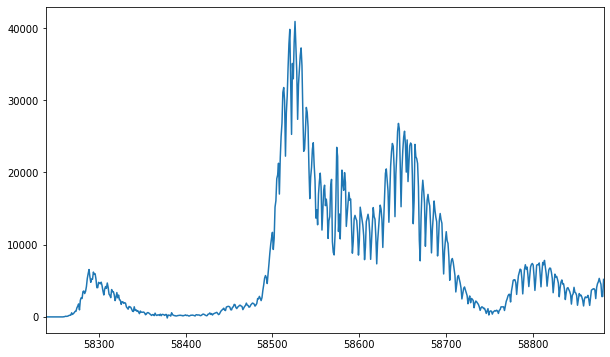

In [5]:
clean_data[clean_data.iso_code == 'ITA']['new_cases'].plot(figsize=(10,6))

In [6]:
# nombrar variable que contenga datos del df determinados

casos_totales_ita = clean_data[clean_data.iso_code == 'ITA']['new_cases'].pct_change().dropna()
casos_totales_ita = casos_totales_ita[(casos_totales_ita <= 1) & (casos_totales_ita >= -1)]

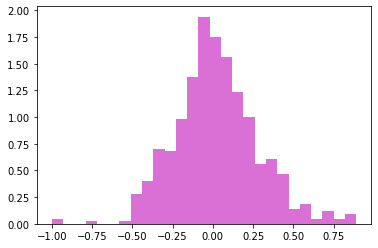

In [7]:
# plotear histograma de los datos

[freq, x_hist, _] = plt.hist(casos_totales_ita, bins="auto", density = True, color= "orchid"); # histograma
plt.show() # mostrar histograma
x_hist = x_hist[1:] # Se obvia el último valor de x para obtener exactamente J muestras de x

C:\Users\dmich\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: `frechet_l` is deprecated!
The distribution `frechet_l` is a synonym for `weibull_max`; this historical
usage is deprecated because of possible confusion with the (quite different)
Frechet distribution.  To preserve the existing behavior of the program, use
`scipy.stats.weibull_max`.  For the Frechet distribution (i.e. the Type II
extreme value distribution), use `scipy.stats.invweibull`.
C:\Users\dmich\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: DeprecationWarning: `frechet_l` is deprecated!
The distribution `frechet_l` is a synonym for `weibull_max`; this historical
usage is deprecated because of possible confusion with the (quite different)
Frechet distribution.  To preserve the existing behavior of the program, use
`scipy.stats.weibull_max`.  For the Frechet distribution (i.e. the Type II
extreme value distribution), use `scipy.stats.invweibull`.
C:\Users\dmich\Anaconda3\lib\site-pack

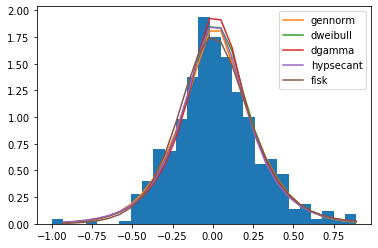

In [9]:
best3 = best_fit_params(casos_totales_ita)

In [11]:
best3

 (1.438968412181508, 0.015063885577456077, 0.2906415177219973),
 (1.1602375640660996, 0.01987820767479649, 0.20822504550826393),
 (1.2418967038042323, 0.01990798828710736, 0.15930553998119984)]

#### La que mejor se ajusta es una función gennorm

### <center> Pruebas de confianza muertes Italia

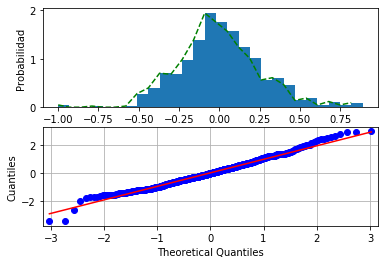

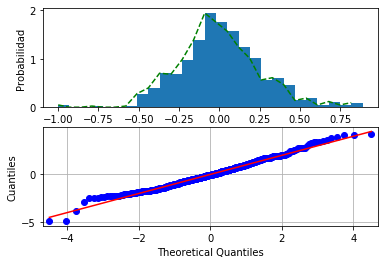

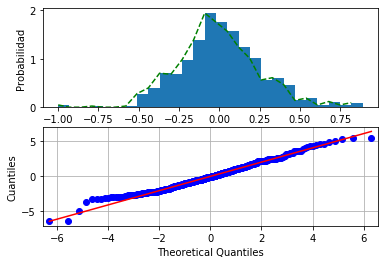

In [13]:
# prueba cuantil-cuantil
for i in range(3):
    qq (casos_totales_ita, best3[i*2], best3[i*2+1])

#### La distribución del conjunto de datos se ajusta bien excepto en las colas

In [14]:
#prueba chi-cuadrada
for i in range(3):
    chi2(best3[i*2], best3[i*2+1], freq, x_hist)

Valor teórico de Chi2 = -91.14351716904503
Valor por librería de Chi2 = Power_divergenceResult(statistic=-91.14351716904503, pvalue=1.0)
Estadístico de Chi2 = 38.885138659830055
Valor teórico de Chi2 = -90.60430153395635
Valor por librería de Chi2 = Power_divergenceResult(statistic=-90.60430153395635, pvalue=1.0)
Estadístico de Chi2 = 38.885138659830055
Valor teórico de Chi2 = -87.79961626940843
Valor por librería de Chi2 = Power_divergenceResult(statistic=-87.79961626940843, pvalue=1.0)
Estadístico de Chi2 = 38.885138659830055


#### El pvalue  es superior a nuestro valor de confianza por lo que si se ajusta.

In [17]:
#prueba de Kolmogorov
for i in range(3):
    prueba_k (casos_totales_ita, best3[i*2], best3[i*2+1])

Se puede ajustar a una gennorm
Se puede ajustar a una dweibull
Se puede ajustar a una dgamma


#### Se confirma que si se puede ajustar a una variable normal 

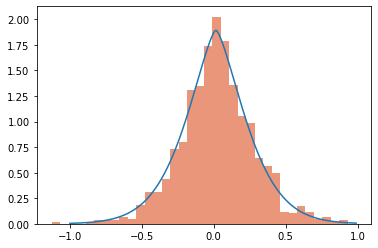

In [21]:
dist = best3[0]
p = best3[1]
var_a_ajustada = trans_inversa(dist, p, 1000)
dom = np.arange(-1,1,0.01)
plt.plot(dom, dist(*p).pdf(dom))
plt.hist(var_a_ajustada, bins="auto", density=True, color="darksalmon")
plt.show()

C:\Users\dmich\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.11241379310344828


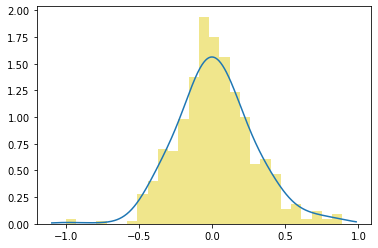

In [22]:
x, pdf = kde(casos_totales_ita, bandwidth = -1) # Para encontrar el mejor bandwidth, bandwidth=-1
plt.plot(x, pdf)
plt.hist(casos_totales_ita.values, bins="auto",density=True, color="khaki")
plt.show()

In [23]:
kde_casos = KernelDensity(bandwidth=0.11241379310344828)
kde_casos.fit(casos_totales_ita.values.reshape(-1, 1))
x_grid = np.linspace(-1, 1, 1000)
pdf_casos = kde_pdf(x_grid[:, None], kde_casos)

var_aleatorias = aceptacion_rechazo(casos_totales_ita.values, kde_pdf, lambda x: max(pdf_casos) * np.ones(len(x)), 10000, kde_casos)


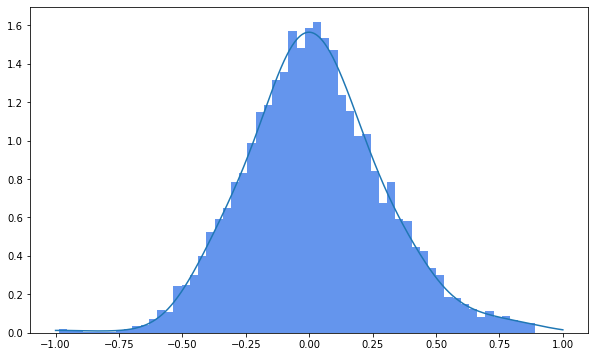

In [24]:
plt.figure(figsize=(10,6))
plt.hist(var_aleatorias, bins="auto", density=True, color="cornflowerblue")
plt.plot(x_grid, pdf_casos)
plt.show()

#### Nos preferimos quedar con la variable aleatoria simulada a partir del gennorm y no del kernel density,

### <center> Simulación Monte Carlo Italia

In [25]:
ultimo_valor = clean_data[clean_data.iso_code == 'ITA']['new_cases'].values[-1]
dias_a_sim = 10
casos_sim = var_a_ajustada.reshape(-1, dias_a_sim).copy()
for i in range(len(casos_sim)):
    casos_sim[i][0] = ultimo_valor * (1 + casos_sim[i][0])
    for j in range(1, dias_a_sim):
        casos_sim[i][j] = casos_sim[i][j-1] * (1 + casos_sim[i][j])

    

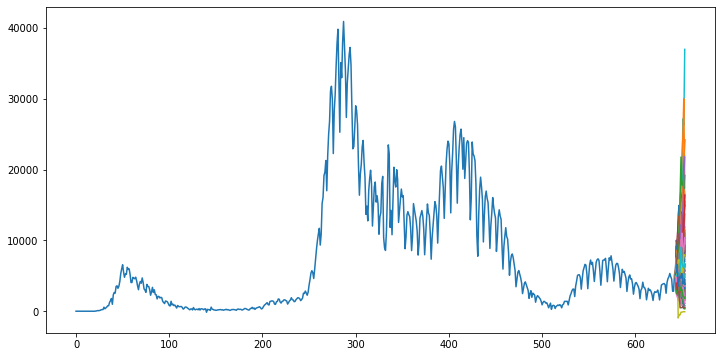

In [26]:
plt.figure(figsize=(12,6))
plt.plot(clean_data[clean_data.iso_code == 'ITA'].reset_index()['new_cases'])
x_ran = len(clean_data[clean_data.iso_code == 'ITA']['new_cases'])
for i in range(len(casos_sim)):
    plt.plot(list(range(x_ran, x_ran + dias_a_sim + 1)), [ultimo_valor] + list(casos_sim[i]))
plt.show()

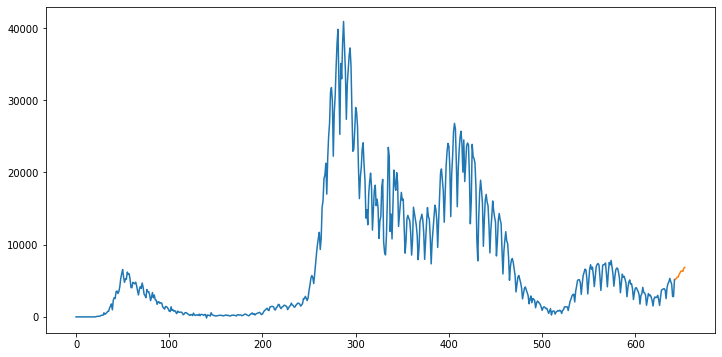

In [28]:
plt.figure(figsize=(12,6))
plt.plot(clean_data[clean_data.iso_code == 'ITA'].reset_index()['new_cases'])
media_sim = casos_sim.mean(axis=0)
plt.plot(list(range(x_ran, x_ran + dias_a_sim + 1)), [ultimo_valor] + list(casos_sim.mean(axis=0)))
plt.show()

In [29]:
media_sim

array([5323.10376222, 5523.80301111, 5520.22535937, 5896.47470337,
       6119.52975174, 6354.34397425, 6325.55475772, 6309.10868154,
       6744.5580307 , 6844.42474786])

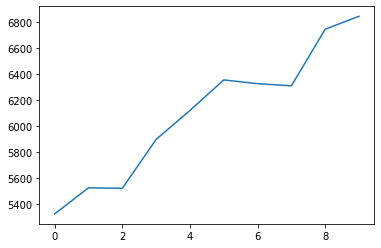

In [31]:
plt.plot(np.array(media_sim))

#### Conclusiones
#### Se espera que con la tendencia que traen los datos de Italia a este punto los casos suban en los siguientes días.

#  <center> Nodo 2. Canadá

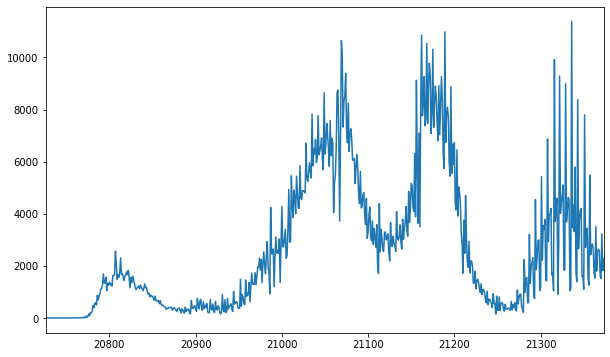

In [32]:
clean_data[clean_data.iso_code == 'CAN']['new_cases'].plot(figsize=(10,6))

In [33]:
# nombrar variable que contenga datos del df determinados

casos_totales_can = clean_data[clean_data.iso_code == 'CAN']['new_cases'].pct_change().dropna()
casos_totales_can = casos_totales_can[(casos_totales_can <= 1) & (casos_totales_can >= -1)]

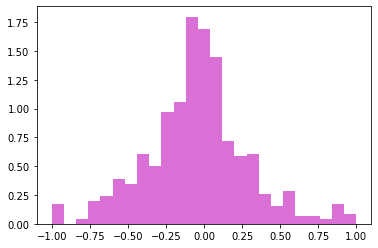

In [34]:
# plotear histograma de los datos

[freq, x_hist, _] = plt.hist(casos_totales_can, bins="auto", density = True, color="orchid"); # histograma
plt.show() # mostrar histograma
x_hist = x_hist[1:] # Se obvia el último valor de x para obtener exactamente J muestras de x

C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:390: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0/np.pi/np.sqrt(x*(1-x))
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1682: RuntimeWarning: invalid value encountered in log
  return log(self._pdf(x, *args))
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:7177: RuntimeWarning: divide by zero encountered in double_scalars
  return chi**3 / (_norm_pdf_C * _argus_phi(chi)) * x * np.sqrt(y) * np.exp(-chi**2 * y / 2)
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:515: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\opt

C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2688: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 234.63934389408928.
  RuntimeWarning)
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2688: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 232.22652258961136.
  RuntimeWarning)
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2688: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 234.0538373104506.
  RuntimeWarning)
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2688: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 234.94590238563467.
  RuntimeWarning)
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2688: RuntimeWarning: The shape parameter of the

C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2688: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 291.12585416012973.
  RuntimeWarning)
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2688: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 291.80099235560317.
  RuntimeWarning)
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2688: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 293.10212607857534.
  RuntimeWarning)
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2688: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 292.06210805863327.
  RuntimeWarning)
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2688: RuntimeWarning: The shape parameter of th

C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2688: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 366.1669148290789.
  RuntimeWarning)
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2688: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 368.248661165763.
  RuntimeWarning)
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2688: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 367.5284210840068.
  RuntimeWarning)
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2688: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 369.86667388995966.
  RuntimeWarning)
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2688: RuntimeWarning: The shape parameter of the er

C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2688: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 432.4734271285299.
  RuntimeWarning)
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2688: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 434.93930653828806.
  RuntimeWarning)
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2688: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 433.3491072207216.
  RuntimeWarning)
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2688: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 434.8105679986677.
  RuntimeWarning)
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2688: RuntimeWarning: The shape parameter of the e

C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:1680: RuntimeWarning: divide by zero encountered in log
  lPx = m/2 * np.log(m) + n/2 * np.log(n) + (n/2 - 1) * np.log(x)
C:\Users\dmich\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: `frechet_l` is deprecated!
The distribution `frechet_l` is a synonym for `weibull_max`; this historical
usage is deprecated because of possible confusion with the (quite different)
Frechet distribution.  To preserve the existing behavior of the program, use
`scipy.stats.weibull_max`.  For the Frechet distribution (i.e. the Type II
extreme value distribution), use `scipy.stats.invweibull`.
C:\Users\dmich\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: DeprecationWarning: `frechet_l` is deprecated!
The distribution `frechet_l` is a synonym for `weibull_max`; this historical
usage is deprecated because of possible confusion with the (quite different)
Frechet distribution.  To preserve the existing be

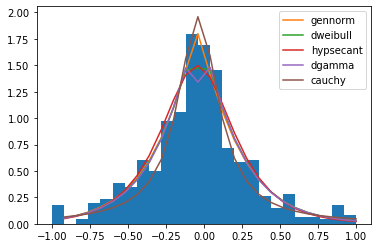

In [35]:
best3 = best_fit_params(casos_totales_can)

In [36]:
best3

 (1.1271865475527054, -0.04417570180793519, 0.28760118655585465),
 (1.0549719751668452, -0.03958216243753211, 0.2517761365748762),
 (-0.044670721876562694, 0.21239009404863182)]

#### La que mejor se ajusta es una función gennorm

### <center> Pruebas de confianza casos nuevos Canáda

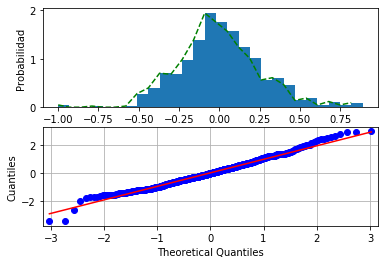

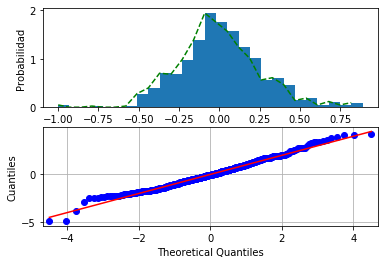

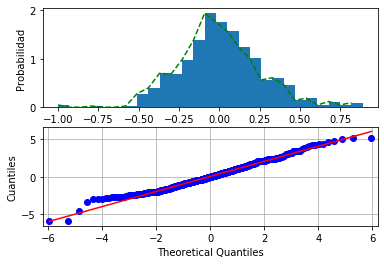

In [37]:
# prueba cuantil-cuantil
for i in range(3):
    qq (casos_totales_ita, best3[i*2], best3[i*2+1])

#### La distribución del conjunto de datos se ajusta bien excepto en las colas

In [38]:
#prueba chi-cuadrada
for i in range(3):
    chi2(best3[i*2], best3[i*2+1], freq, x_hist)

Valor teórico de Chi2 = -9.230343653024446
Valor por librería de Chi2 = Power_divergenceResult(statistic=-9.230343653024446, pvalue=1.0)
Estadístico de Chi2 = 36.41502850180731
Valor teórico de Chi2 = -21.65746618513053
Valor por librería de Chi2 = Power_divergenceResult(statistic=-21.65746618513053, pvalue=1.0)
Estadístico de Chi2 = 36.41502850180731
Valor teórico de Chi2 = -18.406062927869133
Valor por librería de Chi2 = Power_divergenceResult(statistic=-18.406062927869133, pvalue=1.0)
Estadístico de Chi2 = 36.41502850180731


#### El pvalue  es superior a nuestro valor de confianza por lo que si se ajusta.

In [39]:
#prueba de Kolmogorov
for i in range(3):
    prueba_k (casos_totales_ita, best3[i*2], best3[i*2+1])

No se ajusta a una gennorm
No se ajusta a una dweibull
No se ajusta a una hypsecant


#### Se confirma que si se puede ajustar a una variable normal 

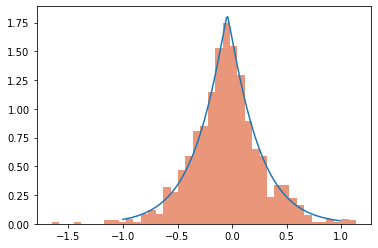

In [40]:
dist = best3[0]
p = best3[1]
var_a_ajustada = trans_inversa(dist, p, 1000)
dom = np.arange(-1,1,0.01)
plt.plot(dom, dist(*p).pdf(dom))
plt.hist(var_a_ajustada, bins="auto", density=True, color="darksalmon")
plt.show()

C:\Users\dmich\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.14655172413793105


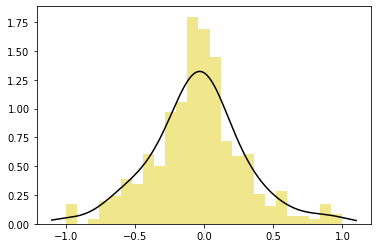

In [53]:
x, pdf = kde(casos_totales_can, bandwidth = -1) # Para encontrar el mejor bandwidth, bandwidth=-1
plt.plot(x, pdf, color= 'black')
plt.hist(casos_totales_can.values, bins="auto",density=True,color='khaki')
plt.show()

In [54]:
kde_casos = KernelDensity(bandwidth=0.14655172413793105)
kde_casos.fit(casos_totales_can.values.reshape(-1, 1))
x_grid = np.linspace(-1, 1, 1000)
pdf_casos = kde_pdf(x_grid[:, None], kde_casos)

var_aleatorias = aceptacion_rechazo(casos_totales_can.values, kde_pdf, lambda x: max(pdf_casos) * np.ones(len(x)), 10000, kde_casos)


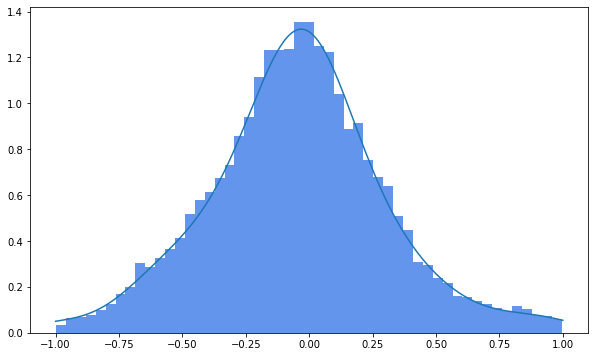

In [55]:
plt.figure(figsize=(10,6))
plt.hist(var_aleatorias, bins="auto", density=True, color="cornflowerblue")
plt.plot(x_grid, pdf_casos)
plt.show()

#### Nos preferimos quedar con una variable aleatoria simulada a partir de gennorm y no de kernel density

### <center> Simulación Monte Carlo Canadá

In [56]:
ultimo_valor = clean_data[clean_data.iso_code == 'CAN']['new_cases'].values[-1]
dias_a_sim = 10
casos_sim = var_aleatorias.reshape(-1, dias_a_sim).copy()
for i in range(len(casos_sim)):
    casos_sim[i][0] = ultimo_valor * (1 + casos_sim[i][0])
    for j in range(1, dias_a_sim):
        casos_sim[i][j] = casos_sim[i][j-1] * (1 + casos_sim[i][j])

    

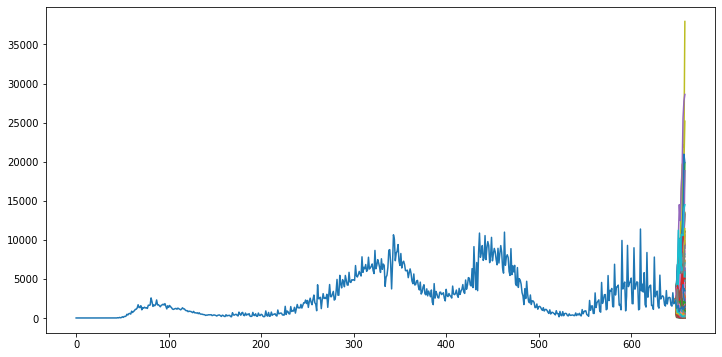

In [57]:
plt.figure(figsize=(12,6))
plt.plot(clean_data[clean_data.iso_code == 'CAN'].reset_index()['new_cases'])
x_ran = len(clean_data[clean_data.iso_code == 'CAN']['new_cases'])
for i in range(len(casos_sim)):
    plt.plot(list(range(x_ran, x_ran + dias_a_sim + 1)), [ultimo_valor] + list(casos_sim[i]))
plt.show()

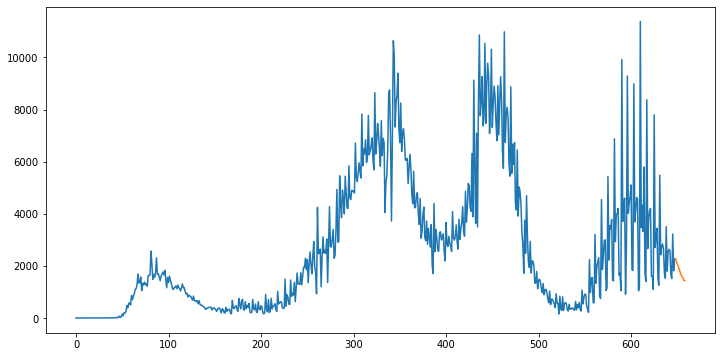

In [63]:
plt.figure(figsize=(12,6))
plt.plot(clean_data[clean_data.iso_code == 'CAN'].reset_index()['new_cases'])
media_sim_can = casos_sim.mean(axis=0)
plt.plot(list(range(x_ran, x_ran + dias_a_sim + 1)), [ultimo_valor] + list(casos_sim.mean(axis=0)))
plt.show()

In [64]:
media_sim_can

array([2155.86199567, 2060.78761677, 1995.13591379, 1875.46549706,
       1765.81833144, 1667.76701365, 1591.65370725, 1539.24231536,
       1450.27900553, 1432.42943937])

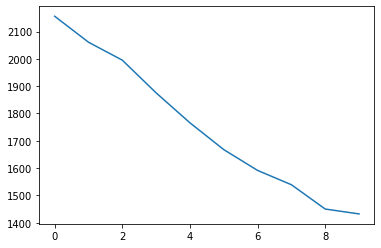

In [65]:
plt.plot(np.array(media_sim_can))

#### Conclusiones
#### Se espera que con la tendencia que traen los datos a este punto los casos bajen en Canadá en los siguientes días.

# <center> Nodo 3: Muertes Italia </center>

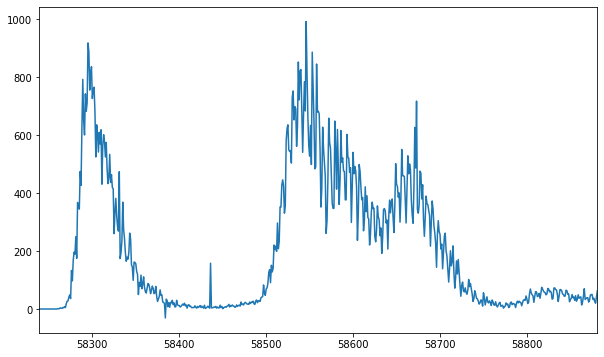

In [66]:
clean_data[clean_data.iso_code == 'ITA']['new_deaths'].plot(figsize=(10,6))

In [67]:
# nombrar variable que contenga datos del df determinados

muertes_totales_i = clean_data[clean_data.iso_code == 'ITA']['new_deaths'].pct_change().dropna()
muertes_totales_i = muertes_totales_i[(muertes_totales_i <= 1) & (muertes_totales_i >= -1)]

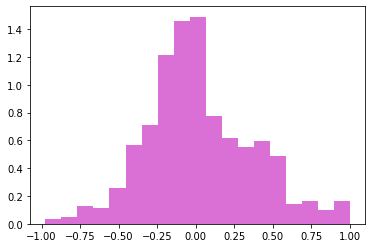

In [68]:
# plotear histograma de los datos

[freq, x_hist, _] = plt.hist(muertes_totales_i, bins="auto", density = True, color= "orchid"); # histograma
plt.show() # mostrar histograma
x_hist = x_hist[1:] # Se obvia el último valor de x para obtener exactamente J muestras de x

C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:390: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0/np.pi/np.sqrt(x*(1-x))
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:667: RuntimeWarning: divide by zero encountered in true_divide
  a/(b-1.0),
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:671: RuntimeWarning: divide by zero encountered in true_divide
  a*(a+1.0)/((b-2.0)*(b-1.0)),
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1059: RuntimeWa

C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2688: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 35.932546522444895.
  RuntimeWarning)
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2688: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 35.965525371260924.
  RuntimeWarning)
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2688: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 35.930299499784454.
  RuntimeWarning)
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2688: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 35.93219528396425.
  RuntimeWarning)
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2688: RuntimeWarning: The shape parameter of the

C:\Users\dmich\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: `frechet_l` is deprecated!
The distribution `frechet_l` is a synonym for `weibull_max`; this historical
usage is deprecated because of possible confusion with the (quite different)
Frechet distribution.  To preserve the existing behavior of the program, use
`scipy.stats.weibull_max`.  For the Frechet distribution (i.e. the Type II
extreme value distribution), use `scipy.stats.invweibull`.
C:\Users\dmich\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: DeprecationWarning: `frechet_l` is deprecated!
The distribution `frechet_l` is a synonym for `weibull_max`; this historical
usage is deprecated because of possible confusion with the (quite different)
Frechet distribution.  To preserve the existing behavior of the program, use
`scipy.stats.weibull_max`.  For the Frechet distribution (i.e. the Type II
extreme value distribution), use `scipy.stats.invweibull`.
C:\Users\dmich\Anaconda3\lib\site-pack

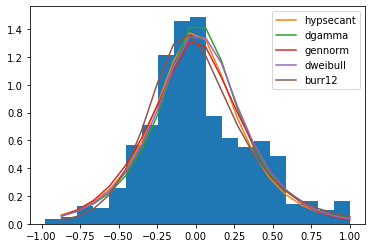

In [69]:
best3 = best_fit_params(muertes_totales_i)

In [70]:
best3

 (-0.006010958601452504, 0.22930680763503902),
 (1.2491626380554657, 0.019102865918639605, 0.21486075494194656),
 (1.5412895963780113, 0.0008961595328358754, 0.41240999455979954)]

#### La que mejor se ajusta es una función gennorm

### <center> Pruebas de confianza muertes Italia

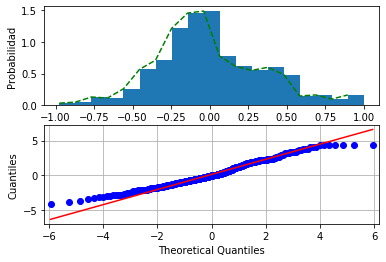

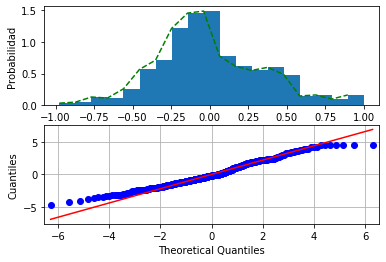

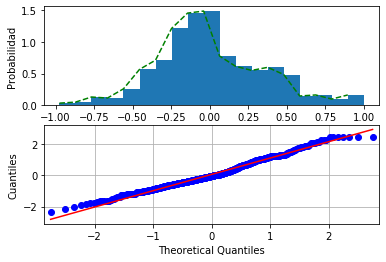

In [80]:
# prueba cuantil-cuantil
for i in range(3):
    qq (muertes_totales_i, best3[i*2], best3[i*2+1])

#### La distribución del conjunto de datos se ajusta bien excepto en las colas

In [81]:
#prueba chi-cuadrada
for i in range(3):
    chi2(best3[i*2], best3[i*2+1], freq, x_hist)

Valor teórico de Chi2 = -33.51718386910878
Valor por librería de Chi2 = Power_divergenceResult(statistic=-33.51718386910878, pvalue=1.0)
Estadístico de Chi2 = 28.869299430392623
Valor teórico de Chi2 = -35.82001785672938
Valor por librería de Chi2 = Power_divergenceResult(statistic=-35.82001785672938, pvalue=1.0)
Estadístico de Chi2 = 28.869299430392623
Valor teórico de Chi2 = -35.36778419739923
Valor por librería de Chi2 = Power_divergenceResult(statistic=-35.36778419739923, pvalue=1.0)
Estadístico de Chi2 = 28.869299430392623


#### El pvalue  es superior a nuestro valor de confianza por lo que si se ajusta.

In [82]:
#prueba de Kolmogorov
for i in range(3):
    prueba_k (casos_totales_ita, best3[i*2], best3[i*2+1])

No se ajusta a una hypsecant
No se ajusta a una dgamma
No se ajusta a una gennorm


#### Se confirma que si se puede ajustar a una variable normal 

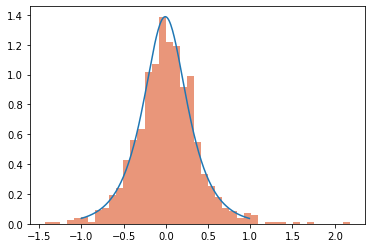

In [83]:
dist = best3[0]
p = best3[1]
var_a_ajustada = trans_inversa(dist, p, 1000)
dom = np.arange(-1,1,0.01)
plt.plot(dom, dist(*p).pdf(dom))
plt.hist(var_a_ajustada, bins="auto", density=True, color="darksalmon")
plt.show()

C:\Users\dmich\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.07827586206896552


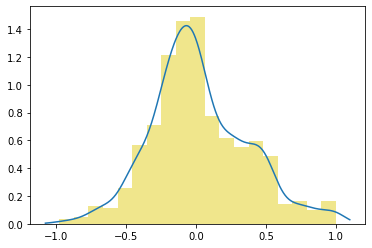

In [84]:
x, pdf = kde(muertes_totales_i, bandwidth = -1) # Para encontrar el mejor bandwidth, bandwidth=-1
plt.plot(x, pdf)
plt.hist(muertes_totales_i.values, bins="auto",density=True, color="khaki")
plt.show()

In [85]:
kde_casos = KernelDensity(bandwidth=0.07827586206896552)
kde_casos.fit(muertes_totales_i.values.reshape(-1, 1))
x_grid = np.linspace(-1, 1, 1000)
pdf_casos = kde_pdf(x_grid[:, None], kde_casos)

var_aleatorias = aceptacion_rechazo(muertes_totales_i.values, kde_pdf, lambda x: max(pdf_casos) * np.ones(len(x)), 10000, kde_casos)

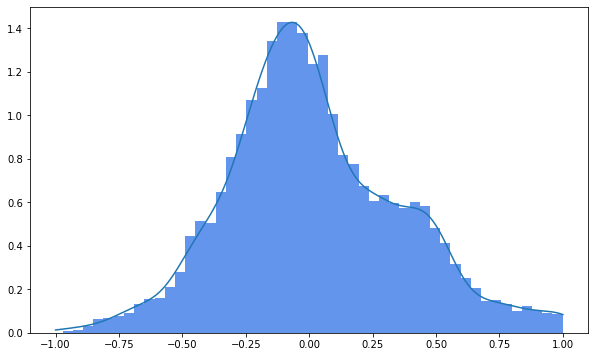

In [86]:
plt.figure(figsize=(10,6))
plt.hist(var_aleatorias, bins="auto", density=True, color="cornflowerblue")
plt.plot(x_grid, pdf_casos)
plt.show()

#### Nos preferimos quedar con la variable aleatoria simulada a partir del gennorm y no del kernel density,

### <center> Simulación Monte Carlo Italia

In [87]:
ultimo_valor = clean_data[clean_data.iso_code == 'ITA']['new_deaths'].values[-1]
dias_a_sim = 10
casos_sim = var_a_ajustada.reshape(-1, dias_a_sim).copy()
for i in range(len(casos_sim)):
    casos_sim[i][0] = ultimo_valor * (1 + casos_sim[i][0])
    for j in range(1, dias_a_sim):
        casos_sim[i][j] = casos_sim[i][j-1] * (1 + casos_sim[i][j])

    

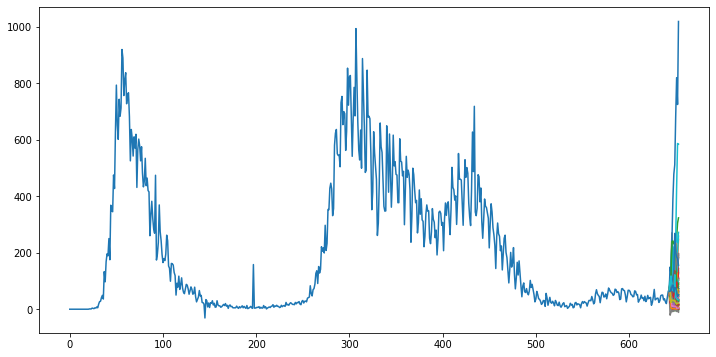

In [88]:
plt.figure(figsize=(12,6))
plt.plot(clean_data[clean_data.iso_code == 'ITA'].reset_index()['new_deaths'])
x_ran = len(clean_data[clean_data.iso_code == 'ITA']['new_deaths'])
for i in range(len(casos_sim)):
    plt.plot(list(range(x_ran, x_ran + dias_a_sim + 1)), [ultimo_valor] + list(casos_sim[i]))
plt.show()

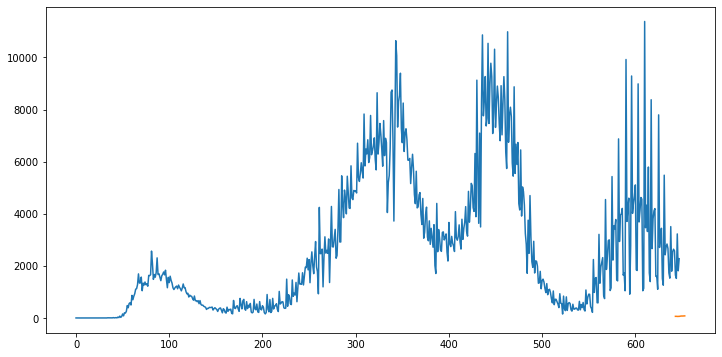

In [90]:
plt.figure(figsize=(12,6))
plt.plot(clean_data[clean_data.iso_code == 'CAN'].reset_index()['new_cases'])
media_sim_ita_m = casos_sim.mean(axis=0)
plt.plot(list(range(x_ran, x_ran + dias_a_sim + 1)), [ultimo_valor] + list(casos_sim.mean(axis=0)))
plt.show()

In [91]:
media_sim_ita_m

array([63.35815553, 59.21427567, 60.84339379, 60.79777088, 67.70999536,
       74.16031883, 74.91258479, 74.94469173, 77.80773302, 79.81794683])

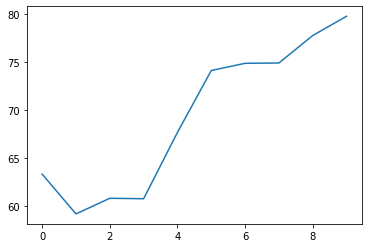

In [92]:
plt.plot(np.array(media_sim_ita_m))

#### Conclusiones
#### Se espera que con la tendencia que traen los datos de Italia a este punto los casos suban en los siguientes días.

# <center> Nodo 4: Muertes Canadá

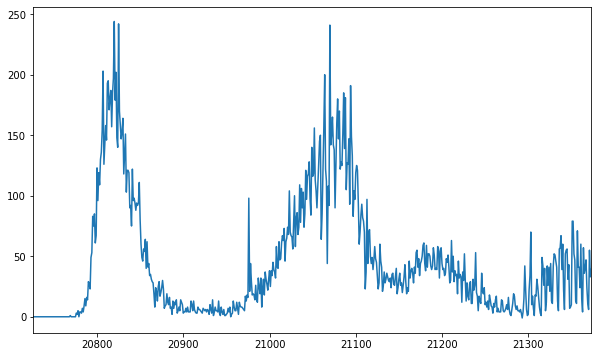

In [94]:
clean_data[clean_data.iso_code == 'CAN']['new_deaths'].plot(figsize=(10,6))

In [95]:
# nombrar variable que contenga datos del df determinados

muertes_nuevas_c = clean_data[clean_data.iso_code == 'CAN']['new_deaths'].pct_change().dropna()
muertes_nuevas_c = muertes_nuevas_c[(muertes_nuevas_c <= 1) & (muertes_nuevas_c >= -1)]

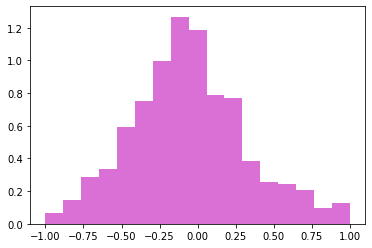

In [96]:
# plotear histograma de los datos

[freq, x_hist, _] = plt.hist(muertes_nuevas_c, bins="auto", density = True, color= "orchid"); # histograma
plt.show() # mostrar histograma
x_hist = x_hist[1:] # Se obvia el último valor de x para obtener exactamente J muestras de x

C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:390: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0/np.pi/np.sqrt(x*(1-x))
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:667: RuntimeWarning: divide by zero encountered in true_divide
  a/(b-1.0),
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:671: RuntimeWarning: divide by zero encountered in true_divide
  a*(a+1.0)/((b-2.0)*(b-1.0)),
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1059: RuntimeWa

C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:1680: RuntimeWarning: divide by zero encountered in log
  lPx = m/2 * np.log(m) + n/2 * np.log(n) + (n/2 - 1) * np.log(x)
C:\Users\dmich\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: `frechet_l` is deprecated!
The distribution `frechet_l` is a synonym for `weibull_max`; this historical
usage is deprecated because of possible confusion with the (quite different)
Frechet distribution.  To preserve the existing behavior of the program, use
`scipy.stats.weibull_max`.  For the Frechet distribution (i.e. the Type II
extreme value distribution), use `scipy.stats.invweibull`.
C:\Users\dmich\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: DeprecationWarning: `frechet_l` is deprecated!
The distribution `frechet_l` is a synonym for `weibull_max`; this historical
usage is deprecated because of possible confusion with the (quite different)
Frechet distribution.  To preserve the existing be

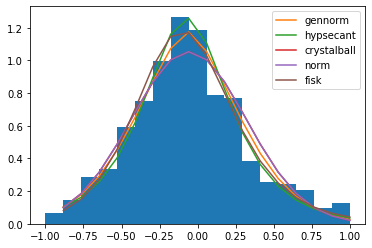

In [97]:
best3 = best_fit_params(muertes_nuevas_c)

In [98]:
best3

 (1.649920338840924, -0.06508430574362713, 0.47591965500503897),
 (-0.07269919978163206, 0.25274477355796227),
 (7.789031417838695,
  18.974908017136748,
  -0.05841524227507594,
  0.378891272323552)]

#### La que mejor se ajusta es una función gennorm

### <center> Pruebas de confianza muertes Canáda

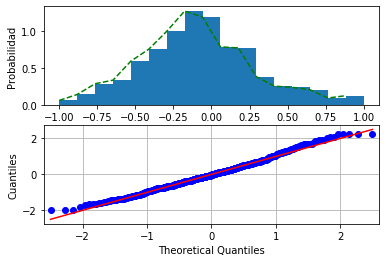

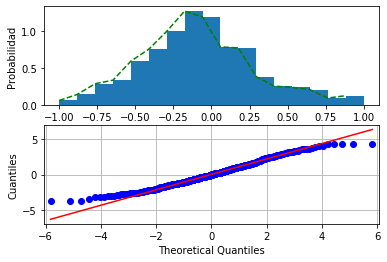

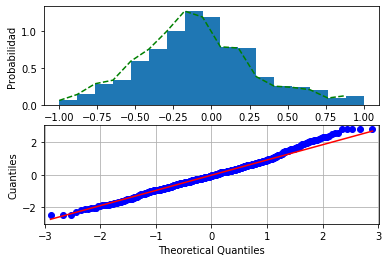

In [99]:
# prueba cuantil-cuantil
for i in range(3):
    qq (muertes_nuevas_c, best3[i*2], best3[i*2+1])

#### La distribución del conjunto de datos se ajusta bien excepto en las colas

In [100]:
#prueba chi-cuadrada
for i in range(3):
    chi2(best3[i*2], best3[i*2+1], freq, x_hist)

Valor teórico de Chi2 = -17.297689113277944
Valor por librería de Chi2 = Power_divergenceResult(statistic=-17.297689113277944, pvalue=1.0)
Estadístico de Chi2 = 26.29622760486423
Valor teórico de Chi2 = -15.922710819363624
Valor por librería de Chi2 = Power_divergenceResult(statistic=-15.922710819363624, pvalue=1.0)
Estadístico de Chi2 = 26.29622760486423
Valor teórico de Chi2 = -19.44279094531193
Valor por librería de Chi2 = Power_divergenceResult(statistic=-19.44279094531193, pvalue=1.0)
Estadístico de Chi2 = 26.29622760486423


#### El pvalue  es superior a nuestro valor de confianza por lo que si se ajusta.

In [101]:
#prueba de Kolmogorov
for i in range(3):
    prueba_k (casos_totales_ita, best3[i*2], best3[i*2+1])

No se ajusta a una gennorm
No se ajusta a una hypsecant
No se ajusta a una crystalball


#### Se confirma que si se puede ajustar a una variable normal 

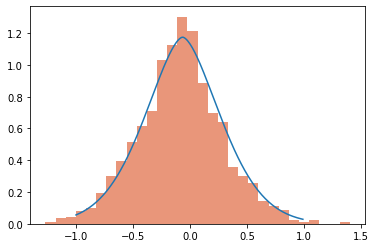

In [102]:
dist = best3[0]
p = best3[1]
var_a_ajustada = trans_inversa(dist, p, 1000)
dom = np.arange(-1,1,0.01)
plt.plot(dom, dist(*p).pdf(dom))
plt.hist(var_a_ajustada, bins="auto", density=True, color="darksalmon")
plt.show()

C:\Users\dmich\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.07827586206896552


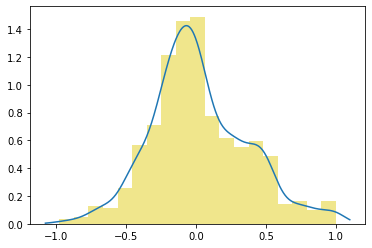

In [103]:
x, pdf = kde(muertes_totales_i, bandwidth = -1) # Para encontrar el mejor bandwidth, bandwidth=-1
plt.plot(x, pdf)
plt.hist(muertes_totales_i.values, bins="auto",density=True, color="khaki")
plt.show()

#### La que mejor se ajusta es una función gennorm

In [ ]:
x, pdf = kde(muertes_nuevas_c, bandwidth = -1) # Para encontrar el mejor bandwidth, bandwidth=-1
plt.plot(x, pdf)
plt.hist(muertes_nuevas_c.values, bins="auto",density=True, color="khaki")
plt.show()

In [ ]:
kde_casos = KernelDensity(bandwidth=0.11241379310344828)
kde_casos.fit(muertes_nuevas_c.values.reshape(-1, 1))
x_grid = np.linspace(-1, 1, 1000)
pdf_casos = kde_pdf(x_grid[:, None], kde_casos)

var_aleatorias = aceptacion_rechazo(muertes_nuevas_c.values, kde_pdf, lambda x: max(pdf_casos) * np.ones(len(x)), 10000, kde_casos)


In [ ]:
plt.figure(figsize=(10,6))
plt.hist(var_aleatorias, bins="auto", density=True, color="cornflowerblue")
plt.plot(x_grid, pdf_casos)
plt.show()

#### Nos preferimos quedar con la variable aleatoria simulada a partir del gennorm y no del kernel density,

### <center> Simulación Monte Carlo Canáda

In [ ]:
ultimo_valor = clean_data[clean_data.iso_code == 'CAN']['new_deaths'].values[-1]
dias_a_sim = 10
casos_sim = var_a_ajustada.reshape(-1, dias_a_sim).copy()
for i in range(len(casos_sim)):
    casos_sim[i][0] = ultimo_valor * (1 + casos_sim[i][0])
    for j in range(1, dias_a_sim):
        casos_sim[i][j] = casos_sim[i][j-1] * (1 + casos_sim[i][j])

    

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(clean_data[clean_data.iso_code == 'CAN'].reset_index()['new_deaths'])
x_ran = len(clean_data[clean_data.iso_code == 'CAN']['new_deaths'])
for i in range(len(casos_sim)):
    plt.plot(list(range(x_ran, x_ran + dias_a_sim + 1)), [ultimo_valor] + list(casos_sim[i]))
plt.show()

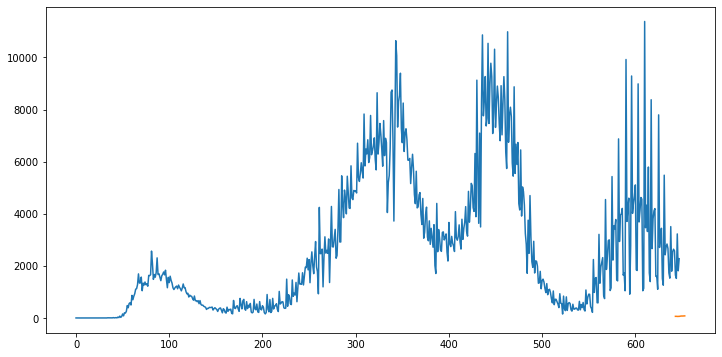

In [105]:
plt.figure(figsize=(12,6))
plt.plot(clean_data[clean_data.iso_code == 'CAN'].reset_index()['new_cases'])
media_sim_can_m = casos_sim.mean(axis=0)
plt.plot(list(range(x_ran, x_ran + dias_a_sim + 1)), [ultimo_valor] + list(casos_sim.mean(axis=0)))
plt.show()

In [106]:
media_sim_can_m

array([63.35815553, 59.21427567, 60.84339379, 60.79777088, 67.70999536,
       74.16031883, 74.91258479, 74.94469173, 77.80773302, 79.81794683])

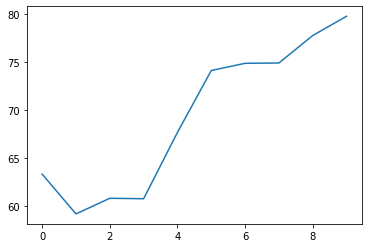

In [107]:
plt.plot(np.array(media_sim_can_m))

#### Conclusiones
#### Se espera que con la tendencia que traen los datos de Italia a este punto los casos suban en los siguientes días.